In [1]:
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt
from numba.decorators import jit

## Task 1

In [2]:
@jit
def test_prob():
    b1=['b','w']
    b2=['b','b']
    nb=ns=0
    for i in range(100000):
        b=random.choice([b1,b2])
        j=random.choice([0,1])
        if b[j]=='b':
            nb+=1
            if b[1-j]=='b':
                ns+=1
    return ns*100.0/nb
print(test_prob())

66.42635772336095


## Task 2

In [3]:
print("{:.3e}".format(    0.45**10    ))
print("{:.3g}".format(    1-(1-0.45**10)**1000    ))

3.405e-04
0.289


## Task 3

In [4]:
def test_hyp():
    for hyp in range(8):
        def n2b(n):
            return list(bin(n)[2:].rjust(3,'0'))
        shyp = n2b(hyp)
        dhyp = ''.join(shyp)
        cnts = [0]*4
        for tgt in range(8):
            stgt = n2b(tgt)
            agn = 0
            for i in range(3):
                if shyp[i]==stgt[i]:
                    agn+=1
            cnts[agn]+=1
        score=cnts[3]*3+cnts[2]*2+cnts[1]*1
        print(f'{dhyp} -> {score}')
test_hyp()

000 -> 12
001 -> 12
010 -> 12
011 -> 12
100 -> 12
101 -> 12
110 -> 12
111 -> 12


## Task 4

In [14]:
vmin = -1.
vmax = 1.

@jit
def rand_points(num=1):
    return np.append(np.ones((num,1)),
                     np.random.random((num,2))*(vmax-vmin)+vmin,
                     axis=1)

@jit
def rand_line():
    return rand_points(2)

@jit
def line2coef(xyline):
    x1, y1 = xyline[0,1], xyline[0,2]
    x2, y2 = xyline[1,1], xyline[1,2]
    # y = ax + b
    a = (y2-y1) / (x2-x1)
    b = y1 - a*x1
    return a,b

def plot_line(xyline, style='k', dots=False):
    def bound_point(x):
        a, b = line2coef(xyline)
        y = a*x+b
        y = min(y, vmax)
        y = max(y, vmin)
        x = (y-b) / a
        return x,y
    x1, y1 = bound_point(vmin)
    x2, y2 = bound_point(vmax)
    line_style = style[0] + '-'
    plt.plot([x1,x2], [y1,y2], line_style)
    if dots:
        dot_style = style
        if len(dot_style) == 1:
            dot_style += 'o'
        plot_points(xyline, dot_style)

def plot_points(points, styles='k'):
    if isinstance(styles, str):
        styles = np.full((points.shape[0],), styles, dtype='<U2')
    for p, s in zip(points, styles):
        if len(s) == 1:
             s += 'o'
        plt.plot([p[1]], [p[2]], s)

@jit
def points_higher(points, xyline):
    a, b = line2coef(xyline)
    return np.sign(points[:,2] - (a*points[:,1]+b))

@jit
def points_sign(p, w):
    return np.sign(np.inner(p, w))

def points_style(farr, garr=None):
    if garr is None:
        garr = farr
    color = np.where(garr == farr, 'b', 'r')
    form = np.where(garr > 0, 'x', '.')
    return np.char.add(color, form)

@jit
def pla(xv, fv, max_iter=0):
    w = np.zeros((3,))
    n_iter = 1
    while 1:
        hv = points_sign(xv, w)
        err = fv - hv
        failed = np.where(err != 0)[0]
        if failed.size == 0 or (max_iter and n_iter > max_iter):
            break
        i = np.random.choice(failed)
        w += err[i] * xv[i]
        n_iter += 1
    return hv, n_iter, failed, w

@jit
def measure_one_pla(n_points, n_prob=1000):
    line = rand_line()
    points1 = rand_points(n_points)
    target1 = points_higher(points1, line)
    approx1, n_iter, failed, weights = pla(points1, target1)
    points3 = rand_points(1000)
    err_num = np.count_nonzero(points_higher(points3, line) != points_sign(points3, weights))
    prob_err = err_num / points3.shape[0]
    return n_iter, prob_err

def measure_avg_pla(n_points, n_iters=1000, n_prob=1000):
    res = np.array([measure_one_pla(n_points, n_prob) for i in range(n_iters)])
    avg_iters = np.mean(res[:,0])
    avg_eprob = np.mean(res[:,1])
    print('n_points=%d iters=%.2f eprob=%.4f' % (n_points, avg_iters, avg_eprob))

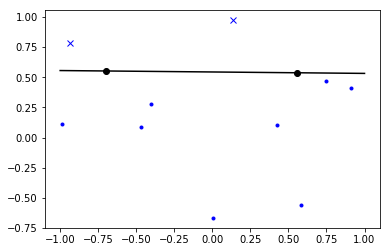

In [12]:
rline = rand_line()
points1 = rand_points(10)
target1 = points_higher(points1, rline)
plot_line(rline, dots=1)
plot_points(points1, points_style(target1))

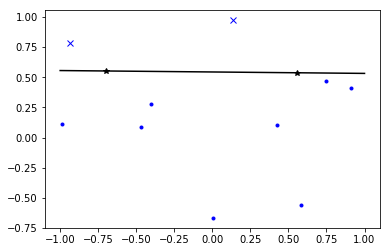

In [13]:
approx1, n_iter, failed, weights = pla(points1, target1)
plot_line(rline, 'k*', dots=True)
plot_points(points1, points_style(target1, approx1))

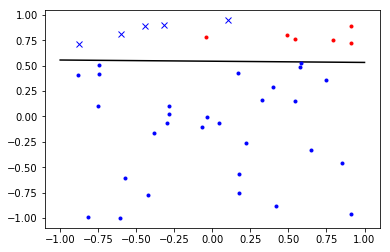

In [15]:
points2 = rand_points(40)
target2 = points_higher(points2, rline)
approx2 = points_sign(points2, weights)
plot_line(rline, 'k*')
plot_points(points2, points_style(target2, approx2))

In [9]:
points3 = rand_points(1000)
err_num = np.count_nonzero(points_higher(points3, rline) != points_sign(points3, weights))
prob_err = err_num / points3.shape[0]
print('prob_err=%.3f' % prob_err)

prob_err=0.192


In [10]:
measure_avg_pla(10, 1000)
measure_avg_pla(100, 1000)

n_points=10 iters=9.95 eprob=0.1112
n_points=100 iters=95.22 eprob=0.0139
